
# UML :

[UML website](http://www.umlet.com/umletino/umletino.html) (import .uxf file)

[Base64 website](https://www.base64-image.de/)

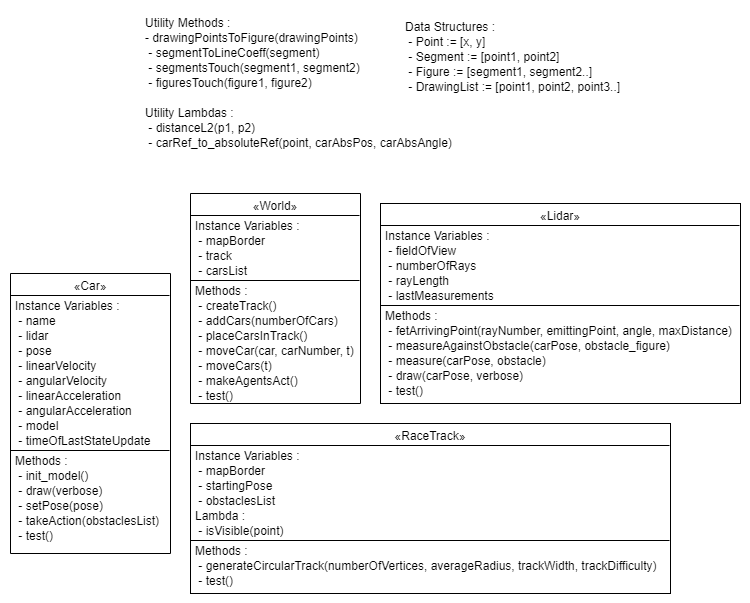




# Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import random

# Utility Functions

These functions are mostly used for sensing drawing

In [0]:


def drawingPointsToFigure(drawingPoints) :
  # drawingPoints is a list of points : [ [p1_x, p1_y], [p2_x, p2_y], [p3_x, p3_y].. ]
  # figure is a list of segments : [ [ [p1, p2], [p2, p3] ], [ ... ] ]
  figure = []
  
  p1 = []
  for i in range(len(drawingPoints)) :
    p2 = p1
    p1 = drawingPoints[i]
    
    if (i > 0) : # No segment if only one point
      figure.append([p1, p2])

  return figure



def segmentToLineCoeff(segment) :
  # Segment : [point1, point2]
  point1 = segment[0]
  point2 = segment[1]

  # Line coeffs : (a, b, c) s.t. a*x + b*y + c = 0
  a = point1[1] - point2[1]
  b = point2[0] - point1[0]
  c = -a*point1[0] - b*point1[1]

  return a, b, c


def segmentsTouch(segment1, segment2) :
  a1, b1, c1 = segmentToLineCoeff(segment1)
  a2, b2, c2 = segmentToLineCoeff(segment2)

  # print("a1, b1, c1 : ", a1, b1, c1)
  # print("a2, b2, c2 : ", a2, b2, c2)

  delta = a1 * b2 - a2 * b1

  if (delta == 0) :
    # Segments are in parallel
    return [ False, [-1, -1] ] # [-1, -1] is the error case

  # TODO : handle the case where the two segments are colinear (but still possibly touching)

  x = (b2 * c1 - b1 * c2) / delta;
  y = (a1 * c2 - a2 * c1) / delta;

  # TODO : Debug the following
  # The tests bellow show a sign inversion, I do not know why
  # Ressources making me think the code is correct :
  #    segmentToLine : https://cp-algorithms.com/geometry/segment-to-line.html
  #    coeffToIntercectionPoint : https://stackoverflow.com/questions/4543506/algorithm-for-intersection-of-2-lines
  x = -x
  y = -y
  # This quick fix seems to work for now, this urgently needs fixing.
  # TODO : Debug above

  def isInSegmentRectangle(point, segment) :
    min_x = min(segment[0][0], segment[1][0])
    max_x = max(segment[0][0], segment[1][0])
    min_y = min(segment[0][1], segment[1][1])
    max_y = max(segment[0][1], segment[1][1])
    return (point[0] >= min_x) and (point[0] <= max_x) and (point[1] >= min_y) and (point[1] <= max_y)

  return [ isInSegmentRectangle([x, y], segment1) and isInSegmentRectangle([x, y], segment2), [x, y] ]


def figuresTouch(figure1, figure2) :
  # A figure is a set of segment. For example : The model of a car and the sides of the track are figures.
  for segment1 in figure1 :
    for segment2 in figure2 :
      tmp = segmentsTouch(segment1, segment2)
      if tmp[0] :
        return tmp # At least one pair of segments touch
  # No pair of segments touch
  return [ False, [-1, -1] ] # [-1, -1] is the error case


distanceL2 = lambda p1, p2 : np.sqrt( (p1[0] - p2[0]) * (p1[0] - p2[0]) + (p1[1] - p2[1]) * (p1[1] - p2[1]))


# Matrice de transformation homogène
#  cos sin carAbsPos_x
# -sin cos carAbsPos_y
#  0   0   1
carRef_to_absoluteRef = lambda point, carAbsPos, carAbsAngle : [carAbsPos[0] + point[0] * np.cos(carAbsAngle) + point[1] * np.sin(carAbsAngle), carAbsPos[1] - point[0] * np.sin(carAbsAngle) + point[1] * np.cos(carAbsAngle)]





In [0]:


# Tests
p1 = [0, 0]
p2 = [0, 1]
p3 = [1, 1]
p4 = [1, 0]
p5 = [0.5, 0.5]

s1 = [p1, p3]
s2 = [p2, p4]
print(f"segmentsTouch({s1}, {s2}) : {segmentsTouch(s1, s2)}")
print(f"segmentsTouch({s2}, {s1}) : {segmentsTouch(s2, s1)}")

s3 = [p1, p2]
s4 = [p3, p4]
s5 = [p2, p3]
s6 = [p4, p5]

print(f"segmentsTouch({s3}, {s4}) : {segmentsTouch(s3, s4)}")

print(f"segmentsTouch({s1}, {s4}) : {segmentsTouch(s1, s4)}")

print(f"segmentsTouch({s3}, {s6}) : {segmentsTouch(s3, s6)}")

# TODO : Reformulate as asserts

fig1 = [s3, s5]
fig2 = [s6]
print(f"figuresTouch({fig1}, {fig2}) : {figuresTouch(fig1, fig2)}")

fig3 = [s6, s1]
print(f"figuresTouch({fig1}, {fig3}) : {figuresTouch(fig1, fig3)}")

# TODO : add regular case of fig intersecting in an X shape ( / and \)

segmentsTouch([[0, 0], [1, 1]], [[0, 1], [1, 0]]) : [True, [0.5, 0.5]]
segmentsTouch([[0, 1], [1, 0]], [[0, 0], [1, 1]]) : [True, [0.5, 0.5]]
segmentsTouch([[0, 0], [0, 1]], [[1, 1], [1, 0]]) : [False, [-1, -1]]
segmentsTouch([[0, 0], [1, 1]], [[1, 1], [1, 0]]) : [True, [1.0, 1.0]]
segmentsTouch([[0, 0], [0, 1]], [[1, 0], [0.5, 0.5]]) : [False, [0.0, 1.0]]
figuresTouch([[[0, 0], [0, 1]], [[0, 1], [1, 1]]], [[[1, 0], [0.5, 0.5]]]) : [False, [-1, -1]]
figuresTouch([[[0, 0], [0, 1]], [[0, 1], [1, 1]]], [[[1, 0], [0.5, 0.5]], [[0, 0], [1, 1]]]) : [True, [0.0, 0.0]]


# Lidar Class

In [0]:

class Lidar :
  def __init__(self) :
    
    self.fieldOfView = 180 # deg
    self.numberOfRays = 18
    self.rayLength = 100 # Max ray range
    self.lastMeasurements = []
    return


  def getArrivingPoint(self, rayNumber, emittingPoint, angle, maxDistance=-1) :
    # maxDistance is used when measures have already been made, to get back the point of contact in that direction
    rayAngle_deg = angle + ((rayNumber - self.numberOfRays / 2) / (self.numberOfRays - 1) * self.fieldOfView)
    rayAngle_rad = rayAngle_deg * 3.14 / 180
    arrivingPoint = [ emittingPoint[0] + np.cos(rayAngle_rad) * self.rayLength, emittingPoint[1] + np.sin(rayAngle_rad) * self.rayLength ]

    if (maxDistance == -1) :
      # No max distance provided, return the point as-is
      return arrivingPoint

    # A valid max distance has been provided -> taking that into account

    currentDistance = distanceL2(emittingPoint, arrivingPoint)
    if (currentDistance < maxDistance) :
      # No need to ajust, the point is not too far
      return arrivingPoint

    # arrivingPoint is too far from emittingPoint, placing it at max distance instead
    arrivingPoint_x = emittingPoint[0] + (arrivingPoint[0] - emittingPoint[0]) * maxDistance / currentDistance
    arrivingPoint_y = emittingPoint[1] + (arrivingPoint[1] - emittingPoint[1]) * maxDistance / currentDistance
    arrivingPoint = [arrivingPoint_x, arrivingPoint_y]

    return arrivingPoint


  def measureAgainstObstacle(self, carPose, obstacle_figure) :
    # carPose is [[pos_x, pos_y], angle_deg]
    obstacleMeasures = []
    emittingPoint = carPose[0]
    for rayNumber in range(self.numberOfRays) :
      arrivingPoint = self.getArrivingPoint(rayNumber, emittingPoint, - carPose[1]) # TODO : Tests showed an inversion of the angle, why ?
      
      ray_segment = [emittingPoint, arrivingPoint]
      ray_figure = [ray_segment]
      
      figuresTouch_bool, touchingPoint = figuresTouch(ray_figure, obstacle_figure)
      
      
      if ( figuresTouch_bool ) : # The ray did touch an obstacle
        rayActualLength = distanceL2(emittingPoint, touchingPoint)
        obstacleMeasures.append(rayActualLength)
      else : # The ray did not touch an obstacle
        obstacleMeasures.append(self.rayLength)
        
    return obstacleMeasures


  def measure(self, carPose, obstaclesList) :
    finalMeasure = []
    for obstacleNumber, obstacle in enumerate(obstaclesList) :
      obstacleFigure = drawingPointsToFigure(obstacle)
      currentMeasure = self.measureAgainstObstacle(carPose, obstacleFigure)
      if (obstacleNumber == 0) :
        finalMeasure = [x for x in currentMeasure]
      else :
        finalMeasure = [min(x, y) for (x, y) in zip(finalMeasure, currentMeasure)]

    self.lastMeasurements = finalMeasure

    return finalMeasure


      
    
  def draw(self, carPose, verbose = False) :
    # This function returns two array : The x and y coordinates of the drawing line.
    if verbose : print("Drawing lidar")

    # First : in the car's referential
    emittingPoint = [0, 0] # In the car referential
    linePoints = []

    
    for rayNumber in range(self.numberOfRays) :
      if (self.lastMeasurements == []) :
        arrivingPoint = self.getArrivingPoint(rayNumber, emittingPoint, 0)
      else :
        arrivingPoint = self.getArrivingPoint(rayNumber, emittingPoint, 0, maxDistance=self.lastMeasurements[rayNumber])

      linePoints.append(emittingPoint)
      linePoints.append(arrivingPoint)

    # Second : in the World's referential
    linePoint_AbsRef = [carRef_to_absoluteRef(x, carPose[0], carPose[1] * 3.14 / 180) for x in linePoints]

    return linePoint_AbsRef


  def test(self) :
    # TODO
    print("test")
    



In [0]:
sensor = Lidar()
carPose = [[5, 5], 0]

obstacle_segment = [[10, 10], [10, 0]]
obstacle_figure = [obstacle_segment]

measurements = sensor.measureAgainstObstacle(carPose, obstacle_figure)
print(measurements)

obstacle_segment2 = [[9, 15], [10, 10]]
obstacle_figure2 = [obstacle_segment2]

obstaclesList = [obstacle_figure, obstacle_figure2]

measurements = sensor.measure(carPose, obstaclesList)
print(measurements)

print("sensor drawing : ", sensor.draw(carPose))



[100, 100, 100, 100, 100, 6.763508132693371, 5.879827663545034, 100, 5.086520130411224, 5.0, 5.086520130411224, 100, 5.879827663545034, 6.763508132693371, 100, 100, 100, 100]
[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
sensor drawing :  [[5.0, 5.0], [-4.142875402949219, -94.58116202056564], [5.0, 5.0], [14.301462035411316, -94.5664742973447], [5.0, 5.0], [32.42936950291326, -91.16459685701724], [5.0, 5.0], [49.624146828139374, -84.49125946069067], [5.0, 5.0], [65.30083834850382, -74.7734849086312], [5.0, 5.0], [78.926132739178, -62.34186586536963], [5.0, 5.0], [90.03650593366926, -47.619318302245524], [5.0, 5.0], [98.25398992514423, -31.106694158301167], [5.0, 5.0], [103.2990310036534, -13.365742667880024], [5.0, 5.0], [105.0, 5.0], [5.0, 5.0], [103.2990310036534, 23.365742667880024], [5.0, 5.0], [98.25398992514423, 41.10669415830117], [5.0, 5.0], [90.03650593366926, 57.619318302245524], [5.0, 5.0], [78.926132739178, 72.34186586536963], [5

# Car class

In [0]:
class Car :
  def __init__(self, pose = [ [0, 0], 0], name="No Name"):
    
    
    self.name = name

    self.lidar = Lidar()

    self.pose = [ [pose[0][0], pose[0][1] ], pose[1] ] # [ [pos_x, pos_y], angle_deg ]
    # self.pose is a copy of input, not a reference

    self.linearVelocity = 1 # unit/s
    self.angularVelocity = 0 # deg/s
    # self.angularVelocity = -2 # deg/s
    
    self.linearAcceleration = 0 # unit/s²
    self.angularAcceleration = 0 # deg/s²

    self.model = [] # [[[x1, y1], [x2, y2]], ...] : An array of segments, each segment is a pair of points (x, y)
    self.init_model()

    self.timeOfLastStateUpdate = -1 # -1 is the initial or error case

    return


  def init_model(self) :
    # This function sets up the list of segments describing the car.
    # All coordinates are relative to the absolute position of the car and its absolute angle.
    # By default, the x axis is in the direction of the car, the y axis goes to the right.

    # self.model.append( [ [x1, y1], [x2, y2] ] ) adds a segment (x1, y1), (x2, y2) to the model

    self.model.append( [ [3, -1], [3, 1] ] ) # The front of the car
    self.model.append( [ [3, 1], [-3, 1] ] ) # The right side of the car
    self.model.append( [ [-3, 1], [-3, -1] ] ) # The back of the car
    self.model.append( [ [-3, -1], [3, -1] ] ) # The left side of the car

    # An arrow to indicate direction
    self.model.append( [ [3, 0], [-3, 0] ] ) # Main axis of the arrow
    self.model.append( [ [2, 0], [0, -1] ] ) # Left part of the arrow
    self.model.append( [ [2, 0], [0, 1] ] ) # Left part of the arrow

    
    
  def draw(self, verbose = False) :
    # This function returns two array : The x and y coordinates of the drawing line.
    if verbose : print("Drawing car")
    
    # First : in the car's referential
    linePoints = []
    linePoints.append(self.model[0][0]) # The front 1
    linePoints.append(self.model[0][1]) # The front 2

    linePoints.append(self.model[1][0]) # The right 1
    linePoints.append(self.model[1][1]) # The right 2

    linePoints.append(self.model[2][0]) # The back 1
    linePoints.append(self.model[2][1]) # The back 2

    linePoints.append(self.model[3][0]) # The left 1
    linePoints.append(self.model[3][1]) # The left 2

    linePoints.append(self.model[4][0]) # Main arrow 1
    linePoints.append(self.model[4][1]) # Main arrow 2
    
    linePoints.append(self.model[5][0]) # Left arrow 1
    linePoints.append(self.model[5][1]) # Left arrow 2

    linePoints.append(self.model[6][0]) # Right arrow 1
    linePoints.append(self.model[6][1]) # Right arrow 2

    # Second : in the World's referential
    linePoint_AbsRef = [carRef_to_absoluteRef(x, self.pose[0], self.pose[1] * 3.14 / 180) for x in linePoints]

    return linePoint_AbsRef


  def setPose(self, pose) :
    # pose is : [[pos_x, pos_y], angle_deg]   

    newPose = [ [ pose[0][0], pose[0][1] ], pose[1] ]
    # newPose is a copy of pose, not a reference
    self.pose = newPose
    return


  def takeAction(self, obstaclesList) :
    
    # TODO : /!\ Include the actual RL /!\
    # TODO : /!\ Include the actual RL /!\
    # TODO : /!\ Include the actual RL /!\

    # This function makes the agent choose accelerations

    measurements = self.lidar.measure(self.pose, obstaclesList)

    # TODO : argmin to reduce code
    minRay = -1
    minRayMeasure = -1
    for rayNumber, rayMeasure in enumerate(measurements) :
      if rayNumber == 0 :
        minRay = rayNumber
        minRayMeasure = rayMeasure

      if rayMeasure < minRayMeasure :
        minRayMeasure = rayMeasure
        minRay = rayNumber

    minRay = minRay - self.lidar.numberOfRays / 2

    if (minRay <= 0) :
      # Closest obstacle is on the right
      self.angularAcceleration = -0.5 * (8 / minRayMeasure)
      self.linearAcceleration = 0
    
    if (minRay > 0) :
      # Closest obstacle is on the left
      self.angularAcceleration = 0.5 * (8 / minRayMeasure)
      self.linearAcceleration = 0
        
    # print("measurements : ", measurements)
    
    return


  def test(self) :
      # TODO
      print("tests")
    
    # TODO : Calculate intercection (or not) between car line and track lines / curve
    
    # TODO : Compute sensors (lidar-like)
    
    # TODO : Set up RL algorithm
    


In [0]:
car = Car(pose = [ [0, 0], 0], name="John")
print("car draw : ", car.draw())
print("lidar draw : ", car.lidar.draw(car.pose))



car draw :  [[3.0, -1.0], [3.0, 1.0], [3.0, 1.0], [-3.0, 1.0], [-3.0, 1.0], [-3.0, -1.0], [-3.0, -1.0], [3.0, -1.0], [3.0, 0.0], [-3.0, 0.0], [2.0, 0.0], [0.0, -1.0], [2.0, 0.0], [0.0, 1.0]]
lidar draw :  [[0.0, 0.0], [-9.14287540294922, -99.58116202056566], [0.0, 0.0], [9.301462035411316, -99.5664742973447], [0.0, 0.0], [27.42936950291326, -96.16459685701724], [0.0, 0.0], [44.624146828139374, -89.49125946069067], [0.0, 0.0], [60.300838348503824, -79.7734849086312], [0.0, 0.0], [73.926132739178, -67.34186586536963], [0.0, 0.0], [85.03650593366928, -52.61931830224553], [0.0, 0.0], [93.25398992514423, -36.106694158301174], [0.0, 0.0], [98.2990310036534, -18.365742667880024], [0.0, 0.0], [100.0, 0.0], [0.0, 0.0], [98.2990310036534, 18.365742667880024], [0.0, 0.0], [93.25398992514423, 36.106694158301174], [0.0, 0.0], [85.03650593366928, 52.61931830224553], [0.0, 0.0], [73.926132739178, 67.34186586536963], [0.0, 0.0], [60.300838348503824, 79.7734849086312], [0.0, 0.0], [44.624146828139374, 

# RaceTrack class

In [0]:
class Racetrack :
  def __init__(self, mapBorder):

    self.mapBorder = mapBorder

    self.isVisible = lambda point : ( (point[0] > self.mapBorder[0][0]) and (point[0] < self.mapBorder[0][1]) and (point[1] > self.mapBorder[1][0]) and (point[1] < self.mapBorder[1][1]))
    # TODO : This lambda is never used. Is it relevant to keep it ?

    self.startingPose = [] # [[pos_x, pos_y], angle_deg]
    self.obstaclesList = [] # Only contains the inner and outer tracks for now.


  def generateCircularTrack(self, numberOfVertices, averageRadius, trackWidth, trackDifficulty) :
    # Generates circular track & beginning point

    vertices = []

    ratios = [trackDifficulty * random.random() for x in range(numberOfVertices)]
    ratios = [(100 + ratio) / 100 for ratio in ratios]

    middleVertices = []
    for vertexNumber in range(numberOfVertices) :
      angle_rad = vertexNumber * 2 * 3.14 / numberOfVertices
      ratio = ratios[vertexNumber]

      x_coord = averageRadius * np.cos(angle_rad)
      y_coord = averageRadius * np.sin(angle_rad)

      middleVertices.append([x_coord * ratio, y_coord * ratio])

    # Closing the loop
    _ = middleVertices[0]
    middleVertices.append(_)

    # Give the track its width
    def norm_squared(vect) :
      return vect[0] * vect[0] + vect[1] * vect[1]

    innerVertices = [ [point[0] * (norm_squared(point) - trackWidth * trackWidth / 4)  / norm_squared(point), point[1] * (norm_squared(point) - trackWidth * trackWidth / 4) / norm_squared(point)] for point in middleVertices]
    outerVertices = [ [point[0] * (norm_squared(point) + trackWidth * trackWidth / 4) / norm_squared(point), point[1] * (norm_squared(point) + trackWidth * trackWidth / 4) / norm_squared(point)] for point in middleVertices]

    # Centering them all
    centerPoint = [(self.mapBorder[0][0] + self.mapBorder[0][1]) / 2, (self.mapBorder[1][0] + self.mapBorder[1][1]) / 2]
    innerVertices = [ [point[0] + centerPoint[0], point[1] + centerPoint[1]] for point in innerVertices]
    outerVertices = [ [point[0] + centerPoint[0], point[1] + centerPoint[1]] for point in outerVertices]

    self.obstaclesList = [innerVertices, outerVertices]

    # startingPose in random
    startingVertex = int(numberOfVertices * random.random())
    innerStart = innerVertices[startingVertex]
    outerStart = outerVertices[startingVertex]
    middlePosition = [(innerStart[0] + outerStart[0]) / 2, (innerStart[1] + outerStart[1]) / 2]
    startingAngle = startingVertex * 360.0 / numberOfVertices
    startingAngle = 360 - startingAngle - 90
    self.startingPose = [middlePosition, startingAngle]

    # TODO : Check if the car is already in contact with the track at the beginning

    return


  def test(self) :
    # TODO
    print("testing")


track = Racetrack([[0, 100], [0, 100]])
numberOfVertices = 30
averageRadius = 20
trackWidth = 25 # %age € [0, 100[
trackDifficulty = 70 # %age € [0, 100[ : This is the amount of deformation of the circle. The more, the harder.
track.generateCircularTrack(numberOfVertices, averageRadius, trackWidth, trackDifficulty)

# World class

In [0]:
# This class contains the cars, the track, and simulates the phisics of the environment
class World :

  def __init__(self, mapBorder) :

    self.mapBorder = mapBorder # ref
    self.carsList = []
    self.track = None

    print("[World] : Created myself.")
    return


  def createTrack(self) :
    self.track = Racetrack(mapBorder) # ref
    numberOfVertices = 30
    averageRadius = 20
    trackWidth = 25 # %age € [0, 50[
    trackDifficulty = 70 # %age € [0, 100[ : This is the amount of deformation of the circle. The more, the harder.
    self.track.generateCircularTrack(numberOfVertices, averageRadius, trackWidth, trackDifficulty)
    print(f"[World] : Created a track.")
    self.placeCarsInTrack()
    return


  def addCars(self, numberOfCars) :
    for _ in range(numberOfCars) :
      newCar = Car(pose = [ [0, 0], 0], name = f"Car {_}")
      self.carsList.append(newCar)
    print(f"[World] : Created {numberOfCars} new cars.")
    return


  def placeCarsInTrack(self) :
    if (self.track is not None) and (self.carsList != []) :
      for carNumber in range(len(self.carsList)) :
        self.carsList[carNumber].setPose(self.track.startingPose)
      print("[World] : Placed cars on the track.")
      return

    if (self.carsList == []) :
      print("[World] : No car to place on the track.")
    else :
      print("[World] : Track does not exist -> Cannot place cars.")
    return


  def moveCar(self, car, carNumber, t) :

    if (car.timeOfLastStateUpdate == -1) : #-1 is the error case
      car.timeOfLastStateUpdate = t
      return

    deltaT = t - car.timeOfLastStateUpdate # Time in s since last update
    assert (deltaT > 0) # By construction, it should always be positive

    car.timeOfLastStateUpdate = t
    
    # TODO : Damping and friction

    def carCrashed(car, obstaclesList) :
      for obstacle in obstaclesList :
        carDrawing = car.draw()
        carFigure = drawingPointsToFigure(carDrawing)
        obstacleFigure = drawingPointsToFigure(obstacle)
        if ( figuresTouch(carFigure, obstacleFigure)[0]) : # figuresTouch return [ bool, [contactPos_x, contactPos_y] ]
          return True # At least one obstacle touches

      return False # No obstacle touches

    if carCrashed(car, self.track.obstaclesList) :
      # The car completly stopes
      # TODO : add minimal (non-zero) speed when crashed ?
      car.linearVelocity = 0
      car.angularVelocity = 0
      car.linearAcceleration = 0
      car.angularAcceleration = 0
    else :
      # TODO : Add a mass param
      car.linearVelocity = car.linearVelocity + deltaT * car.linearAcceleration
      car.angularVelocity = car.angularVelocity + deltaT * car.angularAcceleration

      # TODO : Remove or adapt. Friction should impose maxima
      if car.angularVelocity > 5 :
        car.angularVelocity = 5
      if car.angularVelocity < -5 :
        car.angularVelocity = -5
      
    # Update pose
    deltaPosition_carRef = [deltaT * car.linearVelocity, 0] # Going Straight forward
    deltaPosition_worldRef = carRef_to_absoluteRef(deltaPosition_carRef, car.pose[0], car.pose[1] * 3.14 / 180)

    newPose = [ [ deltaPosition_worldRef[0], deltaPosition_worldRef[1] ], car.pose[1] + deltaT * car.angularVelocity]
    self.carsList[carNumber].pose = newPose

    return


  def moveCars(self, t) :
    # This function simulates the "physics" applied to the cars
    for carNumber, car in enumerate(self.carsList) :
      self.moveCar(car, carNumber, t)


  def makeAgentsAct(self) :
    for car in self.carsList :
      car.takeAction(self.track.obstaclesList)
    return


  def test(self) :
    print("New World")




In [0]:
mapBorder = [[0, 100], [0, 100]] # [[x_min, x_max], [y_min, y_max]]

world = World(mapBorder)
world.addCars(2)

print(f"car0.pose before track creating : {world.carsList[0].pose}")

world.carsList[0].linearVelocity = 2
world.carsList[1].angularVelocity = -4

world.placeCarsInTrack()
world.createTrack()

print(f"car0.pose after track creating : {world.carsList[0].pose}")

world.test()

print("car0 pose before movement ", world.carsList[0].pose)
print("car1 pose before movement ", world.carsList[1].pose)

world.moveCars(0) # t = 0
world.moveCars(1) # t = 1

print("car0 pose after movement ", world.carsList[0].pose)
print("car1 pose after movement ", world.carsList[1].pose)

print(f"id(world.carsList[0]) = {id(world.carsList[0])}")
print(f"id(world.carsList[1]) = {id(world.carsList[1])}")



[World] : Created myself.
[World] : Created 2 new cars.
car0.pose before track creating : [[0, 0], 0]
[World] : Track does not exist -> Cannot place cars.
[World] : Created a track.
[World] : Placed cars on the track.
car0.pose after track creating : [[47.658375713888915, 72.46259063964584], 174.0]
New World
car0 pose before movement  [[47.658375713888915, 72.46259063964584], 174.0]
car1 pose before movement  [[47.658375713888915, 72.46259063964584], 174.0]
car0 pose after movement  [[45.66965613705673, 72.25047169960415], 174.0]
car1 pose after movement  [[46.664015925472825, 72.35653116962499], 170.0]
id(world.carsList[0]) = 139700830023240
id(world.carsList[1]) = 139700829765472


# Animation
( Snippet from [Website](https://medium.com/lambda-school-machine-learning/making-animations-work-in-google-colaboratory-new-home-for-ml-prototyping-c6147186ae75) )

In [0]:


# ========================= Create the world =========================
mapBorder = [[0, 100], [0, 100]] # [[x_min, x_max], [y_min, y_max]]

world = World(mapBorder)

# TODO : Diference between time and step in anbiguous
tMax = 143 # in s # Animation time
# tMax = 5 # in s
numberOfSteps = tMax # 1 point = 1s


# ========================= Create the cars =========================

"""
world.addCars(4)

world.placeCarsInTrack()

# Manual modification of cars for testing
world.carsList[1].angularVelocity = -2.5

world.carsList[2].linearVelocity = 2 * world.carsList[2].linearVelocity
world.carsList[2].angularVelocity = -5

world.carsList[3].linearVelocity = 0
world.carsList[3].angularVelocity = 0
"""
world.addCars(1)
world.placeCarsInTrack()


# ========================= Create the track =========================

world.createTrack()


# ========================= Setup the animation =========================

t_vector = np.linspace(0, tMax, numberOfSteps) # (min, max, #points)

# Set up figure, axes, and plot element
fig, ax = plt.subplots()
plt.close()

ax.set_xlim(mapBorder[0])
ax.set_ylim(mapBorder[1])

# Obstacle placeholders
obstacles_placeholder = []
for _ in range(len(world.track.obstaclesList)) : # One obstacle_placeholder per obstacle
  obstacles_placeholder.append(ax.plot([], [], lw=2))
obstacles_placeholder = [x[0] for x in obstacles_placeholder]  # Original example : " obstacleFigure, = ax.plot([], [], lw=2) "

# Car placeholders
cars_placeholder = []
for _ in range(len(world.carsList)) : # One car_placeholder per obstacle
  cars_placeholder.append(ax.plot([], [], lw=2))
cars_placeholder = [x[0] for x in cars_placeholder]  # Original example : " carFigure, = ax.plot([], [], lw=1) "

# Lidar placeholders
lidars_placeholder = []
for _ in range(len(world.carsList)) : # One car_placeholder per obstacle
  lidars_placeholder.append(ax.plot([], [], lw=0.5, linestyle='dotted'))
lidars_placeholder = [x[0] for x in lidars_placeholder]  # Original example : " carFigure, = ax.plot([], [], lw=1) "



# ========================= Animation init function =========================
# This function plots background each frame.

def init(verbose = False):

  for obstacleNumber, obstacle in enumerate(world.track.obstaclesList) :
    obstacle_x, obstacle_y = zip(*obstacle)
    obstacles_placeholder[obstacleNumber].set_data(obstacle_x, obstacle_y)

  return obstacles_placeholder


# ========================= Animation animate function =========================
# This function is called sequentially.

def animate(i):
  t = t_vector[i]

  # TODO : t is not the step
  # print(f"\nt : {t}")

    # Agents chose linear / angular accelerations
  world.makeAgentsAct()

  # Environnement updates the state of the cars
  world.moveCars(t)



  # TODO : Env. should give car the reward

  
  # Draw all cars
  for carNumber, car in enumerate(world.carsList) :
    carDrawing = car.draw() # carDrawing is a figure
    carDrawing_x = [pos[0] for pos in carDrawing]
    carDrawing_y = [pos[1] for pos in carDrawing]
    cars_placeholder[carNumber].set_data(carDrawing_x, carDrawing_y) # This has to be drawable

  # Draw lidars
  for lidarNumber, car in enumerate(world.carsList) :
    lidar = car.lidar
    lidarDrawing = lidar.draw(car.pose) # lidarDrawing is a figure
    lidarDrawing_x = [pos[0] for pos in lidarDrawing]
    lidarDrawing_y = [pos[1] for pos in lidarDrawing]
    lidars_placeholder[lidarNumber].set_data(lidarDrawing_x, lidarDrawing_y) # This has to be drawable



  
    
  return cars_placeholder



# ========================= Animate =========================
# This function generates and aggregates the animation frames together.

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=tMax, interval=100, blit=True)
rc('animation', html='jshtml')
anim


# TODO : Possibility to download a gif of the animation
# TODO : include a gif of cars racing to this notebook, in base64

# TODO : Add drifting + sound ?
# This link reads music files : https://colab.research.google.com/drive/1Zo6iSPIi6SjOAL7wg8yzVWkS9mjLgjI-#scrollTo=yKU0bIbhCGq9

[World] : Created myself.
[World] : Created 1 new cars.
[World] : Track does not exist -> Cannot place cars.
[World] : Created a track.
[World] : Placed cars on the track.


# Debug - Random testing

example of integrated gif, b64

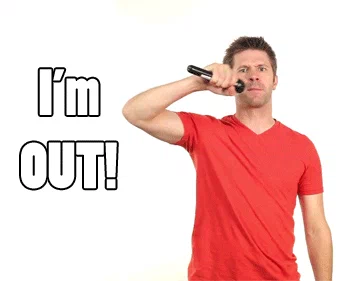

In [0]:
l1 = [1, 2, 2]
l2 = [3, 4, 5]

l3 = zip(l1, l2)
print(l3)

In [0]:

class c1 :
  def __init__(self) :
    self.var = 42
    
  def print(self) :
    print(self.var)

  def update(self, value) :
    self.var = value
    
objList = []
objNumber = 2
for _ in range(objNumber) :
  obj = c1()
  objList.append(obj)

for obj in objList :
  obj.print()

print()

for obj in objList :
  obj.var = 666

print()

for obj in objList :
  obj.print()

print()

for objnumb in range(len(objList)) :
  objList[objnumb].var = 2019

print()

for obj in objList :
  obj.print()

print()

for objnumb in range(len(objList)) :
  objList[objnumb].update(2048)

print()

for obj in objList :
  obj.print()


  

42
42


666
666


2019
2019


2048
2048
